In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [110]:
import sys
import os
repos_path = os.path.join('C:\\','Users','LevineLab','Documents','Repos')
if repos_path not in sys.path:
    sys.path.append(repos_path)


#from pycromanager import Acquisition, multi_d_acquisition_events, Dataset, Core, Studio# , Bridge
import numpy as np
import matplotlib.pyplot as plt
import time


import threading
import datetime

import pycro_scope_control.pycro_funcs as pf
import pycro_scope_control.analysis_funcs as af

from skimage import morphology, exposure, filters, measure
from scipy import signal, ndimage
import copy
from scipy import stats

import heapq
import json


import pandas as pd
import math

In [111]:
def read_datetime_file(file_path):
    """for opening the wash schedule created by pump when the pump program is started"""
    datetime_list = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            date_time_obj = datetime.datetime.strptime(line, '%Y-%m-%d %H:%M:%S.%f')
            datetime_list.append(date_time_obj)

    return datetime_list

In [112]:
def compute_steps_time(steps):
    runtime = 0
    for s in steps:
        if s['type']=='pvflow':
            runtime+=(s['v']/s['r'])+s['post_wait']/60
    return runtime

def get_steps_1port_inject_flow(source = 7,chip = 2,waste = 3,buffer = 4,post_wait = 4):

    steps = [{'type':'pvflow','p':source,'r':300,'v':300,'d':'Withdraw','post_wait':post_wait,'status':'1port injection flow, step1/7, withdraw p{}'.format(source)},
             {'type':'pvflow','p':chip,'r':200,'v':100,'d':'Infuse','post_wait':post_wait,'status':'1port injection flow, step2/7 pulse to device p{}'.format(chip)},
             {'type':'pvflow','p':chip,'r':12,'v':48,'d':'Infuse','post_wait':post_wait,'status':'1port injection flow, step3/7 flow to device p{}'.format(chip)},
             {'type':'pvflow','p':chip,'r':200,'v':100,'d':'Infuse','post_wait':post_wait,'status':'1port injection flow, step4/7 pulse to device p{}'.format(chip)},
             {'type':'pvflow','p':chip,'r':12,'v':48,'d':'Infuse','post_wait':post_wait,'status':'1port injection flow, step5/7 flow to device p{}'.format(chip)},
             {'type':'pvflow','p':waste,'r':600,'v':300,'d':'Infuse','post_wait':post_wait,'status':'1port injection flow, step6/7 to waste p{}'.format(waste)},
             {'type':'pvflow','p':buffer,'r':600,'v':300,'d':'Withdraw','post_wait':post_wait,'status':'1port injection flow, step7/7 wdr buffer p{}'.format(buffer)}]
    return steps

def get_steps_1port_inject_flow_notify(message,source = 7,chip = 2,waste = 3,buffer = 4,post_wait = 4):

    steps = [{'type':'pvflow','p':source,'r':300,'v':300,'d':'Withdraw','post_wait':post_wait,'status':'1port injection flow, step1/7, withdraw p{}'.format(source)},
             {'type':'pvflow','p':chip,'r':200,'v':100,'d':'Infuse','post_wait':post_wait,'status':'1port injection flow, step2/7 pulse to device p{}'.format(chip)}
            ] + get_steps_notify(message) +[
        {'type':'pvflow','p':chip,'r':12,'v':48,'d':'Infuse','post_wait':post_wait,'status':'1port injection flow, step3/7 flow to device p{}'.format(chip)},
             {'type':'pvflow','p':chip,'r':200,'v':100,'d':'Infuse','post_wait':post_wait,'status':'1port injection flow, step4/7 pulse to device p{}'.format(chip)},
             {'type':'pvflow','p':chip,'r':12,'v':48,'d':'Infuse','post_wait':post_wait,'status':'1port injection flow, step5/7 flow to device p{}'.format(chip)},
             {'type':'pvflow','p':waste,'r':600,'v':300,'d':'Infuse','post_wait':post_wait,'status':'1port injection flow, step6/7 to waste p{}'.format(waste)},
             {'type':'pvflow','p':buffer,'r':600,'v':300,'d':'Withdraw','post_wait':post_wait,'status':'1port injection flow, step7/7 wdr buffer p{}'.format(buffer)}
    ]
    return steps

def get_steps_wash_chip(chip = 2,waste = 3,buffer = 4,post_wait = 4):
    steps = [{'type':'pvflow','p':chip,'r':200,'v':300,'d':'Infuse','post_wait':post_wait,'status':'wash chip,step1/3, pulse buffer to chip p{}'.format(chip)},
             {'type':'pvflow','p':chip,'r':12,'v':36,'d':'Infuse','post_wait':post_wait,'status':'wash chip,step2/3, flow buffer to chip p{}'.format(chip)},
             {'type':'pvflow','p':buffer,'r':600,'v':336,'d':'Withdraw','post_wait':post_wait,'status':'wash chip,step3/3, refill buffer p{}'.format(buffer)}]
    return steps


def get_steps_flow_simpletest(source = 7,chip = 2,waste = 3,buffer = 4):

    steps = [{'type':'pvflow','p':source,'r':1000,'v':300,'d':'Withdraw','post_wait':4,'status':'test,step1 withdraw p{}'.format(source)},
             {'type':'pvflow','p':chip,'r':200,'v':10,'d':'Infuse','post_wait':4,'status':'test,step2 p{}'.format(chip)}]
    return steps

def get_steps_switch_source(source = 8,chip = 2,waste = 3,buffer = 4):

    steps = [{'type':'pvflow','p':source,'r':300,'v':300,'d':'Withdraw','post_wait':4,'status':'clean source, step1/3, withdraw p{}'.format(source)},
             {'type':'pvflow','p':waste,'r':300,'v':600,'d':'Infuse','post_wait':4,'status':'clean source, step2/3 to waste p{}'.format(waste)},
             {'type':'pvflow','p':buffer,'r':600,'v':300,'d':'Withdraw','post_wait':4,'status':'clean source, step 3/3 wdr buffer p{}'.format(buffer)}]
    return steps



def get_steps_notify(message,fname = 'jupyter_com'):
    return [{'type':'notify','com_file':r'C:\Users\LevineLab\Documents\Repos\PumpValveSystem\pump_coms\{}'.format(fname),
             'message':'{}'.format(message)}]

def get_steps_make_schedule(cycle_times):
    return [{'type':'make_schedule','file_name':r'C:\Users\LevineLab\Documents\Repos\Pumps\wash_schedule',
             'cycle_times':cycle_times}]


def get_steps_2port_inject_flow(source1=3, source2=4, chip=6, waste=3, buffer=8,post_wait = 4):
    steps = [{'type': 'pvflow', 'p': source1, 'r': 300, 'v': 150, 'd': 'Withdraw', 'post_wait': post_wait,
              'status': '2port injection flow, step1/7, withdraw p{}'.format(source1)},
             {'type': 'pvflow', 'p': source2, 'r': 300, 'v': 150, 'd': 'Withdraw', 'post_wait': post_wait,
              'status': '2port injection flow, step1/7, withdraw p{}'.format(source2)},
             {'type': 'pvflow', 'p': chip, 'r': 200, 'v': 100, 'd': 'Infuse', 'post_wait': post_wait,
              'status': '2port injection flow, step2/7 pulse to device p{}'.format(chip)},
             {'type': 'pvflow', 'p': chip, 'r': 12, 'v': 48, 'd': 'Infuse', 'post_wait': 2,
              'status': '2port injection flow, step3/7 flow to device p{}'.format(chip)},
             {'type': 'pvflow', 'p': chip, 'r': 200, 'v': 100, 'd': 'Infuse', 'post_wait': 2,
              'status': '2port injection flow, step4/7 pulse to device p{}'.format(chip)},
             {'type': 'pvflow', 'p': chip, 'r': 12, 'v': 48, 'd': 'Infuse', 'post_wait': post_wait,
              'status': '2port injection flow, step5/7 flow to device p{}'.format(chip)},
             {'type': 'pvflow', 'p': waste, 'r': 600, 'v': 300, 'd': 'Infuse', 'post_wait': post_wait,
              'status': '2port injection flow, step6/7 to waste p{}'.format(waste)},
             {'type': 'pvflow', 'p': buffer, 'r': 600, 'v': 300, 'd': 'Withdraw', 'post_wait': post_wait,
              'status': '2port injection flow, step7/7 wdr buffer p{}'.format(buffer)}]
    return steps


def get_steps_pulse_port(port=1, vol=30, rate=300, direction='Infuse'):
    steps = [{'type': 'pvflow', 'p': port, 'r': rate, 'v': vol, 'd': 'Infuse', 'post_wait': 4,
              'status': 'pulse_port p{}'.format(port)}]
    return steps



def create_PV_program_1h_alternate_2_species_v2(source1_port=4, source2_port=3, cycles=6):
    master_steps = []
    # pump_num = 0
    """ injection flow cycles from source 1, cycles are about 11.5 minutes"""
    for cycle in range(cycles):
        wash_num = cycle*2
        for inject in range(5):
            master_steps += get_steps_1port_inject_flow(source=source1_port, chip=6, waste=7, buffer=8,post_wait = 8)
        master_steps += get_steps_pulse_port(port=source1_port, vol=30, rate=300, direction='Infuse')
        master_steps += get_steps_notify('starting_wash {}'.format(wash_num), fname='jupyter_com_pumps')
        master_steps += get_steps_wash_chip(chip=6, waste=7, buffer=8,post_wait = 8)
        
        wash_num = cycle*2+1
        for inject in range(5):
            master_steps += get_steps_1port_inject_flow(source=source2_port, chip=6, waste=7, buffer=8,post_wait = 8)
        master_steps += get_steps_pulse_port(port=source2_port, vol=30, rate=300, direction='Infuse')
        master_steps += get_steps_notify('starting_wash {}'.format(wash_num), fname='jupyter_com_pumps')
        master_steps += get_steps_wash_chip(chip=6, waste=7, buffer=8, post_wait = 8)

    """compute the approximate time for each cycle and add this list as a make schedule step"""
    cycle_time = get_approx_times_between_notify_v2(master_steps)
    master_steps = get_steps_make_schedule(cycle_time) + master_steps
    return master_steps,cycle_time

def create_PV_program_simultenious_species_v2(source1_port=3, source2_port=4, source1_cycles=6, source2_cycles=6):
    master_steps = []
    # pump_num = 0
    """ injection flow cycles from source 1, cycles are about 11.5 minutes"""
    for cycle in range(source1_cycles):
        if cycle % 2 == 0:
            s1 = source1_port
            s2 = source2_port
        else:
            s1 = source2_port
            s2 = source1_port
        master_steps += get_steps_2port_inject_flow(source1=s1, source2=s2, chip=6, waste=7, buffer=8,post_wait = 8)
        master_steps += get_steps_2port_inject_flow(source1=s2, source2=s1, chip=6, waste=7, buffer=8,post_wait = 8)
        master_steps += get_steps_2port_inject_flow(source1=s1, source2=s2, chip=6, waste=7, buffer=8,post_wait = 8)
        master_steps += get_steps_2port_inject_flow(source1=s2, source2=s1, chip=6, waste=7, buffer=8,post_wait = 8)
        master_steps += get_steps_2port_inject_flow(source1=s1, source2=s2, chip=6, waste=7, buffer=8,post_wait = 8)

        master_steps += get_steps_notify('starting_wash {}'.format(cycle), fname='jupyter_com_pumps')
        master_steps += get_steps_wash_chip(chip=6, waste=7, buffer=8,post_wait = 8)

    """ injection flow cycles from source 2, cycles are about 11.5 minutes"""
    for cycle in range(source1_cycles, source1_cycles + source2_cycles):
        if cycle % 2 == 0:
            s1 = source1_port
            s2 = source2_port
        else:
            s1 = source2_port
            s2 = source1_port
        master_steps += get_steps_2port_inject_flow(source1=s1, source2=s2, chip=6, waste=7, buffer=8,post_wait = 8)
        master_steps += get_steps_2port_inject_flow(source1=s2, source2=s1, chip=6, waste=7, buffer=8,post_wait = 8)
        master_steps += get_steps_2port_inject_flow(source1=s1, source2=s2, chip=6, waste=7, buffer=8,post_wait = 8)
        master_steps += get_steps_2port_inject_flow(source1=s2, source2=s1, chip=6, waste=7, buffer=8,post_wait = 8)
        master_steps += get_steps_2port_inject_flow(source1=s1, source2=s2, chip=6, waste=7, buffer=8,post_wait = 8)

        master_steps += get_steps_notify('starting_wash {}'.format(cycle), fname='jupyter_com_pumps')

        master_steps += get_steps_wash_chip(chip=6, waste=7, buffer=8,post_wait = 8)
    """compute the approximate time for each cycle and add this list as a make schedule step"""
    cycle_time = get_approx_times_between_notify_v2(master_steps)
    master_steps = get_steps_make_schedule(cycle_time) + master_steps
    return master_steps,cycle_time


# my2species_prog = create_PV_program_simultenious_species()
#my2species_prog = create_PV_program_simultenious_species_42m_rounds()

def create_PV_program_sequential_2_species_v2(source1_port = 3,source2_port = 4,source1_cycles = 5,source2_cycles = 7):
    master_steps = []
    # pump_num = 0
    """ injection flow cycles from source 1, cycles are about 11.5 minutes"""
    for cycle in range(source1_cycles):
        for inject in range(5):
            master_steps += get_steps_1port_inject_flow(source=source1_port, chip=6, waste=7, buffer=8)

        master_steps += get_steps_notify('starting_wash {}'.format(cycle), fname='jupyter_com_pumps')
        master_steps += get_steps_wash_chip(chip=6, waste=7, buffer=8)

    """ when switching source, dispense to waste a full ml to clear out remaining species 1,
    and withdraw from source and dispense to waste to re prime source 2 tubing"""
    master_steps += get_steps_switch_source(source=source2_port, chip=6, waste=7, buffer=8)

    """ injection flow cycles from source 2, cycles are about 11.5 minutes"""
    for cycle in range(source1_cycles, source1_cycles+source2_cycles):
        for inject in range(5):
            master_steps += get_steps_1port_inject_flow(source=source2_port, chip=6, waste=7, buffer=8)

        master_steps += get_steps_notify('starting_wash {}'.format(cycle), fname='jupyter_com_pumps')

        master_steps += get_steps_wash_chip(chip=6, waste=7, buffer=8)
    """compute the approximate time for each cycle and add this list as a make schedule step"""
    cycle_time = get_approx_times_between_notify_v2(master_steps)
    master_steps = get_steps_make_schedule(cycle_time) + master_steps
    return master_steps,cycle_time


def create_PV_program_sequential_2_species_v3(source1_port = 3,source2_port = 4,source1_cycles = 8,source2_cycles = 8):
    imaging_round = 0
    master_steps = []
    # pump_num = 0
    """ injection flow cycles from source 1, cycles are about 11.5 minutes"""
    for cycle in range(source1_cycles):
        #for inject in range(5):
        # 5 steps of injection flow, notify every other
        master_steps += get_steps_1port_inject_flow(source=source1_port, chip=6, waste=7, buffer=8)
        master_steps += get_steps_1port_inject_flow_notify(message = 'imaging_ready {}'.format(imaging_round),source=source1_port, chip=6, waste=7, buffer=8)
        imaging_round +=1
        master_steps += get_steps_1port_inject_flow(source=source1_port, chip=6, waste=7, buffer=8)
        master_steps += get_steps_1port_inject_flow_notify(message = 'imaging_ready {}'.format(imaging_round),source=source1_port, chip=6, waste=7, buffer=8)
        imaging_round +=1
        master_steps += get_steps_1port_inject_flow(source=source1_port, chip=6, waste=7, buffer=8)
        
        master_steps += get_steps_notify('imaging_ready {}'.format(imaging_round), fname='jupyter_com_pumps')
        imaging_round +=1
        master_steps += get_steps_wash_chip(chip=6, waste=7, buffer=8)

    """ when switching source, dispense to waste a full ml to clear out remaining species 1,
    and withdraw from source and dispense to waste to re prime source 2 tubing"""
    
    """added step to clean both ports"""
    master_steps += get_steps_switch_source(source=source1_port, chip=6, waste=7, buffer=8)
    master_steps += get_steps_switch_source(source=source2_port, chip=6, waste=7, buffer=8)

    """ injection flow cycles from source 2, cycles are about 11.5 minutes"""
    for cycle in range(source1_cycles, source1_cycles+source2_cycles):
        #for inject in range(5):
        # 5 steps of injection flow, notify every other
        master_steps += get_steps_1port_inject_flow(source=source2_port, chip=6, waste=7, buffer=8)
        master_steps += get_steps_1port_inject_flow_notify(message = 'imaging_ready {}'.format(imaging_round),source=source2_port, chip=6, waste=7, buffer=8)
        imaging_round +=1
        master_steps += get_steps_1port_inject_flow(source=source2_port, chip=6, waste=7, buffer=8)
        master_steps += get_steps_1port_inject_flow_notify(message = 'imaging_ready {}'.format(imaging_round),source=source2_port, chip=6, waste=7, buffer=8)
        imaging_round +=1
        master_steps += get_steps_1port_inject_flow(source=source2_port, chip=6, waste=7, buffer=8)
        
        master_steps += get_steps_notify('imaging_ready {}'.format(imaging_round), fname='jupyter_com_pumps')
        imaging_round +=1
        master_steps += get_steps_wash_chip(chip=6, waste=7, buffer=8)
    """compute the approximate time for each cycle and add this list as a make schedule step"""
    cycle_time = get_approx_times_between_notify_v2(master_steps)
    master_steps = get_steps_make_schedule(cycle_time) + master_steps
    return master_steps,cycle_time


def create_PV_program_2h_alternating_2_species_v3(source1_port = 3,source2_port = 4,source1_cycles = 8,source2_cycles = 8):
    imaging_round = 0
    master_steps = []
    # pump_num = 0
    """ injection flow cycles from source 1, cycles are about 11.5 minutes"""
    
    for h2 in range(4):
        if h2 ==2:
            master_steps += get_steps_switch_source(source=source1_port, chip=6, waste=7, buffer=8)
            master_steps += get_steps_switch_source(source=source2_port, chip=6, waste=7, buffer=8)
            
        for c in range(2):
            #for inject in range(5):
            # 5 steps of injection flow, notify every other
            master_steps += get_steps_1port_inject_flow(source=source1_port, chip=6, waste=7, buffer=8)
            master_steps += get_steps_1port_inject_flow_notify(message = 'imaging_ready {}'.format(imaging_round),source=source1_port, chip=6, waste=7, buffer=8)
            imaging_round +=1
            master_steps += get_steps_1port_inject_flow(source=source1_port, chip=6, waste=7, buffer=8)
            master_steps += get_steps_1port_inject_flow_notify(message = 'imaging_ready {}'.format(imaging_round),source=source1_port, chip=6, waste=7, buffer=8)
            imaging_round +=1
            master_steps += get_steps_1port_inject_flow(source=source1_port, chip=6, waste=7, buffer=8)

            master_steps += get_steps_notify('imaging_ready {}'.format(imaging_round), fname='jupyter_com_pumps')
            imaging_round +=1
            master_steps += get_steps_wash_chip(chip=6, waste=7, buffer=8)


        """ injection flow cycles from source 2, cycles are about 11.5 minutes"""
        for c in range(2):
            #for inject in range(5):
            # 5 steps of injection flow, notify every other
            master_steps += get_steps_1port_inject_flow(source=source2_port, chip=6, waste=7, buffer=8)
            master_steps += get_steps_1port_inject_flow_notify(message = 'imaging_ready {}'.format(imaging_round),source=source2_port, chip=6, waste=7, buffer=8)
            imaging_round +=1
            master_steps += get_steps_1port_inject_flow(source=source2_port, chip=6, waste=7, buffer=8)
            master_steps += get_steps_1port_inject_flow_notify(message = 'imaging_ready {}'.format(imaging_round),source=source2_port, chip=6, waste=7, buffer=8)
            imaging_round +=1
            master_steps += get_steps_1port_inject_flow(source=source2_port, chip=6, waste=7, buffer=8)

            master_steps += get_steps_notify('imaging_ready {}'.format(imaging_round), fname='jupyter_com_pumps')
            imaging_round +=1
            master_steps += get_steps_wash_chip(chip=6, waste=7, buffer=8)
    """compute the approximate time for each cycle and add this list as a make schedule step"""
    cycle_time = get_approx_times_between_notify_v2(master_steps)
    master_steps = get_steps_make_schedule(cycle_time) + master_steps
    return master_steps,cycle_time


def get_approx_times_between_notify_v2(steps):
    cycle_times = []
    runtime = 0
    for s in steps:
        if s['type']=='pvflow':
            runtime+=(s['v']/s['r'])+(s['post_wait']+3.2)/60
        elif s['type']=='notify':
            cycle_times.append(round(runtime,2))
            runtime = 0
    return cycle_times


def write_pump_program_json(master_steps,file_name=None):
    """write the sequnce PV steps into a json
    file will have 'name'=filename, and 'sequence_steps'=master_steps
    witten in the directory of the pumping program
    """
    if file_name is None:
        file_name = "pump_prog_4_26_23_1.json"
    pump_prog = {'name': file_name,
                 'sequence_steps': master_steps}
    with open(r'C:\Users\LevineLab\Documents\Repos\PumpValveSystem\json_progs\{}'.format(pump_prog['name']), 'w') as f:
        json.dump(pump_prog, f, indent=4)

In [113]:
def prog_table(phases,time_increments = 10):
# Create an empty DataFrame with columns for ports 1-8
    df = pd.DataFrame(columns=[str(i) for i in range(1, 9)])

    for phase in phases:
        if phase['type'] == 'pvflow':
            duration = math.ceil(((phase['v'] / phase['r'] * 60)) / time_increments)  # We use math.ceil() to round up
            #runtime+=(s['v']/s['r'])+(s['post_wait']+3.2)/60
            # Initialize a dictionary for the new DataFrame rows
            data = {str(i): 0 for i in range(1, 9)}
            # Set the rate for the correct port
            data[str(phase['p'])] = phase['r'] if phase['d'].lower() == 'withdraw' else -phase['r']  # Withdraw: positive rate, Infuse: negative rate
            # Create new DataFrame rows for the current phase and append them to the DataFrame
            rows = pd.DataFrame([data]*duration)
            df = pd.concat([df, rows], ignore_index=True)
            
            post_wait_duration = math.ceil((phase['post_wait']+3) / time_increments)
            data[str(phase['p'])] = 0  # Reset the rate for the post_wait period
            post_wait_rows = pd.DataFrame([data]*int(post_wait_duration))
            df = pd.concat([df, post_wait_rows], ignore_index=True)
        else:
            continue
    df.insert(0, 'time_seconds', pd.Series(range(len(df))) * time_increments)
    return df



def plot_program_phases(df,start_hour = 0, hours = 1, wt = None):
    start_time = (start_hour) *60*60
    end_time = (start_hour+hours) *60*60

    # Slice the DataFrame to include only the rows within the chosen time range
    df_portion = df[(df['time_seconds'] >= start_time) & (df['time_seconds'] <= end_time)]

    plt.figure(figsize = [12,6])
    for port in df.columns[1:]:  # Exclude the 'time_seconds' column
        plt.plot(df_portion['time_seconds']/60, df_portion[port], label=f'Port {port}')

    plt.xlabel('Time (mins)')
    plt.ylabel('Rate (vol/minute)')
    plt.title('Rate over time for each port (withdraw is positive)')
    plt.legend()
    plt.grid(True)
    if wt is not None:
        wt = accumulate_values(wt)
        plt.scatter(wt,np.ones((len(wt)))*-100)
        plt.xlim([start_time/60-10,end_time/60+10])
    
def accumulate_values(numbers):
    accumulated_list = []
    accumulator = 0
    for num in numbers:
        accumulator += num
        accumulated_list.append(accumulator)
    return accumulated_list

In [114]:
# simul_prog = create_PV_program_simultenious_species_v2()
# simul_prog

In [115]:
# for s in simul_prog[0]:
#     if s['type'] == 'notify':
#         print(s['message'])

In [116]:
# alter_prog = create_PV_program_1h_alternate_2_species_v2()
# alter_prog

In [117]:
# for s in alter_prog[0]:
#     if s['type'] == 'notify':
#         print(s['message'])

In [118]:
# write_pump_program_json(seq_prog,"sequential_2species_json2.json")

# alternating 2 h

In [119]:
alt_prog,wait_times = create_PV_program_2h_alternating_2_species_v3()
alt_prog

[{'type': 'make_schedule',
  'file_name': 'C:\\Users\\LevineLab\\Documents\\Repos\\Pumps\\wash_schedule',
  'cycle_times': [13.58,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   26.72,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94]},
 {'type': 'pvflow',
  'p': 3,
  'r': 300,
  'v': 300,
  'd': 'Withdraw',
  'post_wait': 4,
  'status': '1port injection flow, step1/7, withdraw p3'},
 {'type': 'pvflow',
  'p': 6,
  'r': 200,
  'v': 100,
  'd': 'Infuse',
  'post_wait': 4,
  'status': '1port injection flow, step2/7 pulse to device p6'},
 {'type': 'pvflow',
  'p': 6,
  'r': 12,
  'v': 48,
  'd': 'Infuse',
  'post_wait': 4,
  'status': '1port i

In [120]:
for s in alt_prog:
    if s['type'] == 'notify':
        print(s['message'])

imaging_ready 0
imaging_ready 1
imaging_ready 2
imaging_ready 3
imaging_ready 4
imaging_ready 5
imaging_ready 6
imaging_ready 7
imaging_ready 8
imaging_ready 9
imaging_ready 10
imaging_ready 11
imaging_ready 12
imaging_ready 13
imaging_ready 14
imaging_ready 15
imaging_ready 16
imaging_ready 17
imaging_ready 18
imaging_ready 19
imaging_ready 20
imaging_ready 21
imaging_ready 22
imaging_ready 23
imaging_ready 24
imaging_ready 25
imaging_ready 26
imaging_ready 27
imaging_ready 28
imaging_ready 29
imaging_ready 30
imaging_ready 31
imaging_ready 32
imaging_ready 33
imaging_ready 34
imaging_ready 35
imaging_ready 36
imaging_ready 37
imaging_ready 38
imaging_ready 39
imaging_ready 40
imaging_ready 41
imaging_ready 42
imaging_ready 43
imaging_ready 44
imaging_ready 45
imaging_ready 46
imaging_ready 47


In [122]:
ports = {f'{i}':0 for i in range(1,9)}
for s in alt_prog:
    if s['type'] == 'pvflow':
        ports[str(s['p'])]+=s['v']
ports

{'1': 0,
 '2': 0,
 '3': 12300,
 '4': 12300,
 '5': 0,
 '6': 29056,
 '7': 25200,
 '8': 29976}

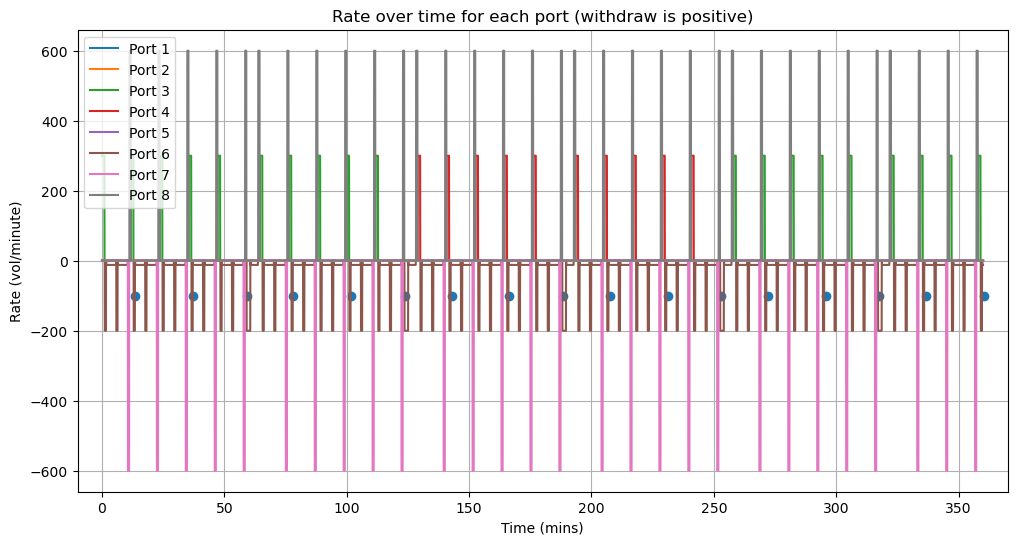

In [123]:


df = prog_table(alt_prog,time_increments=1)
plot_program_phases(df,start_hour = 0,hours = 6,wt = wait_times)

# sequantial program

In [124]:
seq_prog,_ = create_PV_program_sequential_2_species_v3()
seq_prog

[{'type': 'make_schedule',
  'file_name': 'C:\\Users\\LevineLab\\Documents\\Repos\\Pumps\\wash_schedule',
  'cycle_times': [13.58,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   26.72,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94,
   19.0,
   23.68,
   21.94]},
 {'type': 'pvflow',
  'p': 3,
  'r': 300,
  'v': 300,
  'd': 'Withdraw',
  'post_wait': 4,
  'status': '1port injection flow, step1/7, withdraw p3'},
 {'type': 'pvflow',
  'p': 6,
  'r': 200,
  'v': 100,
  'd': 'Infuse',
  'post_wait': 4,
  'status': '1port injection flow, step2/7 pulse to device p6'},
 {'type': 'pvflow',
  'p': 6,
  'r': 12,
  'v': 48,
  'd': 'Infuse',
  'post_wait': 4,
  'status': '1port i

In [125]:
for s in seq_prog:
    if s['type'] == 'notify':
        print(s['message'])

imaging_ready 0
imaging_ready 1
imaging_ready 2
imaging_ready 3
imaging_ready 4
imaging_ready 5
imaging_ready 6
imaging_ready 7
imaging_ready 8
imaging_ready 9
imaging_ready 10
imaging_ready 11
imaging_ready 12
imaging_ready 13
imaging_ready 14
imaging_ready 15
imaging_ready 16
imaging_ready 17
imaging_ready 18
imaging_ready 19
imaging_ready 20
imaging_ready 21
imaging_ready 22
imaging_ready 23
imaging_ready 24
imaging_ready 25
imaging_ready 26
imaging_ready 27
imaging_ready 28
imaging_ready 29
imaging_ready 30
imaging_ready 31
imaging_ready 32
imaging_ready 33
imaging_ready 34
imaging_ready 35
imaging_ready 36
imaging_ready 37
imaging_ready 38
imaging_ready 39
imaging_ready 40
imaging_ready 41
imaging_ready 42
imaging_ready 43
imaging_ready 44
imaging_ready 45
imaging_ready 46
imaging_ready 47


In [94]:
#write_pump_program_json(seq_prog,"sequential_2species_json2.json")

In [95]:
seq_prog[0]['cycle_times']

[13.58,
 23.68,
 21.94,
 19.0,
 23.68,
 21.94,
 19.0,
 23.68,
 21.94,
 19.0,
 23.68,
 21.94,
 19.0,
 23.68,
 21.94,
 19.0,
 23.68,
 21.94,
 19.0,
 23.68,
 21.94,
 19.0,
 23.68,
 21.94,
 26.72,
 23.68,
 21.94,
 19.0,
 23.68,
 21.94,
 19.0,
 23.68,
 21.94,
 19.0,
 23.68,
 21.94,
 19.0,
 23.68,
 21.94,
 19.0,
 23.68,
 21.94,
 19.0,
 23.68,
 21.94,
 19.0,
 23.68,
 21.94]

In [96]:
""" total vol at port """
ports = {f'{i}':0 for i in range(1,9)}
for s in seq_prog:
    if s['type'] == 'pvflow':
        ports[str(s['p'])]+=s['v']
ports

{'1': 0,
 '2': 0,
 '3': 12300,
 '4': 12300,
 '5': 0,
 '6': 29056,
 '7': 25200,
 '8': 29976}

In [126]:
""" total vol at port """
ports = {f'{i}':0 for i in range(1,9)}
for s in seq_prog:
    if s['type'] == 'pvflow':
        ports[str(s['p'])]+=s['v']
for s in seq_prog:
    if s['type'] == 'pvflow':
        ports[str(s['p'])]+=s['v']
for s in alt_prog:
    if s['type'] == 'pvflow':
        ports[str(s['p'])]+=s['v']
        
ports

{'1': 0,
 '2': 0,
 '3': 36900,
 '4': 36900,
 '5': 0,
 '6': 87168,
 '7': 75600,
 '8': 89928}

In [97]:

wt = accumulate_values(wt)

NameError: name 'wt' is not defined

In [98]:
# s1 = np.array(alter_prog[0][0]['cycle_times'])
# for i in range(len(s1)-1):
#     s1[i+1] +=s1[i]
# s1

In [99]:
# s2 = np.array(simul_prog[0][0]['cycle_times'])
# for i in range(len(s2)-1):
#     s2[i+1] +=s2[i]
# s2

In [100]:
# plt.figure(figsize = [12,12])
# plt.plot(np.arange(len(s1)),s1,marker = '+')
# #plt.plot(np.arange(len(s1)),s1+5)
# plt.plot(np.arange(len(s2)),s2+8,marker = '+')
# #plt.plot(np.arange(len(s2)),s2+15,marker = '+')
# plt.grid(axis='y', linestyle='--', which='both')

# plt.plot(np.arange(len(s1)),s1-22,marker = '+')
# plt.plot(np.arange(len(s2)),s2+8-22,marker = '+')
# #plt.plot(np.arange(len(s2)),s2+15-35,marker = '+')



# plt.plot(np.arange(len(s1)),s1-44,marker = '+')
# plt.plot(np.arange(len(s2)),s2+8-44,marker = '+')

In [101]:
# import pandas as pd
# import math

# def prog_table(phases,time_increments = 10):
# # Create an empty DataFrame with columns for ports 1-8
#     df = pd.DataFrame(columns=[str(i) for i in range(1, 9)])

#     for phase in phases:
#         if phase['type'] == 'pvflow':
#             duration = math.ceil(((phase['v'] / phase['r'] * 60)) / time_increments)  # We use math.ceil() to round up
#             #runtime+=(s['v']/s['r'])+(s['post_wait']+3.2)/60
#             # Initialize a dictionary for the new DataFrame rows
#             data = {str(i): 0 for i in range(1, 9)}
#             # Set the rate for the correct port
#             data[str(phase['p'])] = phase['r'] if phase['d'].lower() == 'withdraw' else -phase['r']  # Withdraw: positive rate, Infuse: negative rate
#             # Create new DataFrame rows for the current phase and append them to the DataFrame
#             rows = pd.DataFrame([data]*duration)
#             df = pd.concat([df, rows], ignore_index=True)
            
#             post_wait_duration = math.ceil((phase['post_wait']+3) / time_increments)
#             data[str(phase['p'])] = 0  # Reset the rate for the post_wait period
#             post_wait_rows = pd.DataFrame([data]*int(post_wait_duration))
#             df = pd.concat([df, post_wait_rows], ignore_index=True)
#         else:
#             continue
#     df.insert(0, 'time_seconds', pd.Series(range(len(df))) * time_increments)
#     return df



# def plot_program_phases(df,start_hour = 0, hours = 1, wt = None):
#     start_time = (start_hour) *60*60
#     end_time = (start_hour+hours) *60*60

#     # Slice the DataFrame to include only the rows within the chosen time range
#     df_portion = df[(df['time_seconds'] >= start_time) & (df['time_seconds'] <= end_time)]

#     plt.figure(figsize = [12,6])
#     for port in df.columns[1:]:  # Exclude the 'time_seconds' column
#         plt.plot(df_portion['time_seconds']/60, df_portion[port], label=f'Port {port}')

#     plt.xlabel('Time (mins)')
#     plt.ylabel('Rate (vol/minute)')
#     plt.title('Rate over time for each port (withdraw is positive)')
#     plt.legend()
#     plt.grid(True)
#     if wt is not None:
#         wt = accumulate_values(wt)
#         plt.scatter(wt,np.ones((len(wt)))*-100)
#         plt.xlim([start_time/60-10,end_time/60+10])
    
# def accumulate_values(numbers):
#     accumulated_list = []
#     accumulator = 0
#     for num in numbers:
#         accumulator += num
#         accumulated_list.append(accumulator)
#     return accumulated_list

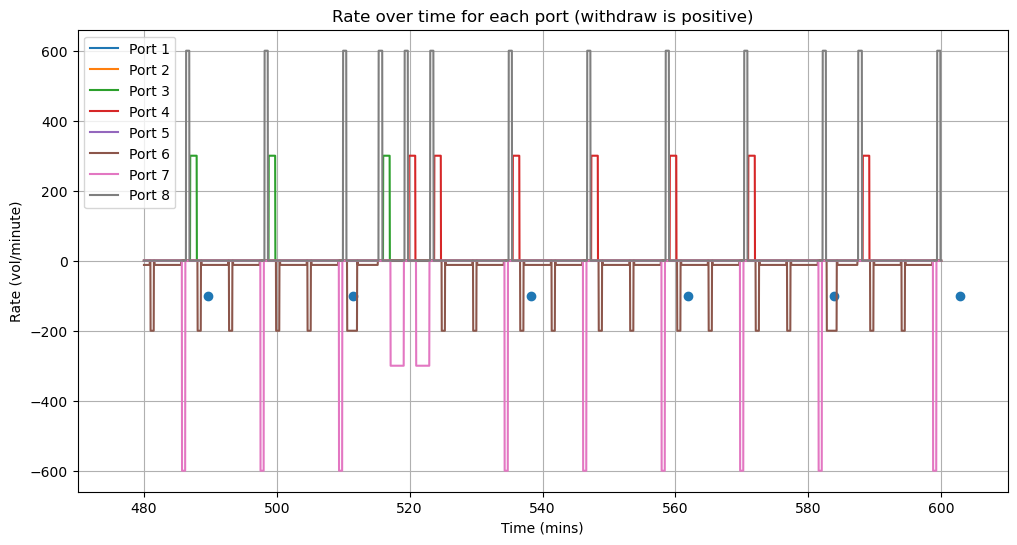

In [102]:

#simul_prog,wait_times = create_PV_program_simultenious_species_v2()
seq_prog,wait_times = create_PV_program_sequential_2_species_v3()
seq_prog

df = prog_table(seq_prog,time_increments=1)
plot_program_phases(df,start_hour = 8,hours = 2,wt = wait_times)
# plt.scatter(wt,np.ones((len(wt)))*-400)
# plt.xlim([-10,350])

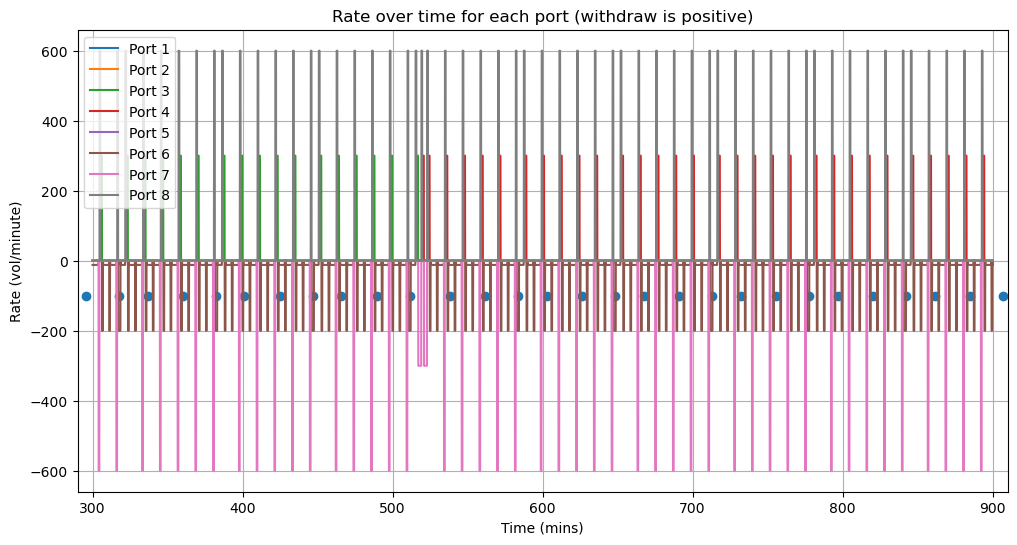

In [103]:
plot_program_phases(df,start_hour = 5,hours = 10,wt = wait_times)

In [104]:
write_pump_program_json(seq_prog,"sequntial_2species_8h.json")

# compute the imaging times

In [105]:
seq_prog,wait_times_seq = create_PV_program_sequential_2_species_v3()

alt_prog,wait_times_alt = create_PV_program_2h_alternating_2_species_v3()

In [106]:
acc_seq = np.array(accumulate_values(wait_times_seq))

acc_seq2 = acc_seq+6

acc_alt = np.array(accumulate_values(wait_times_alt))+12

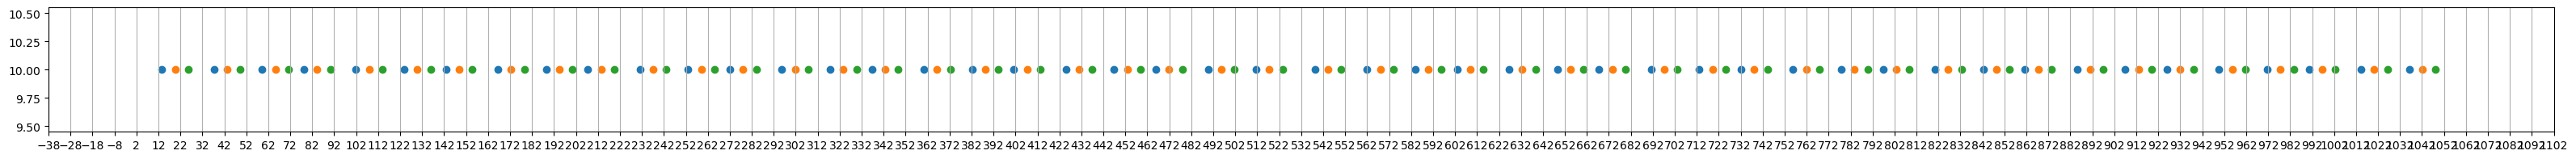

In [107]:
plt.figure(figsize = [40,2])
plt.scatter(acc_seq,np.ones(acc_seq.shape)*10)
plt.scatter(acc_seq2,np.ones(acc_seq2.shape)*10)
plt.scatter(acc_alt,np.ones(acc_alt.shape)*10)

xmin, xmax = plt.xlim()
xticks_positions = np.arange(int(xmin), int(xmax) + 10, 10)
plt.xticks(xticks_positions)
plt.grid(axis='x')

In [108]:
write_pump_program_json(seq_prog,"sequntial8h_2species_16h.json")
write_pump_program_json(alt_prog,"alter2h_2species_16h.json")

## old code

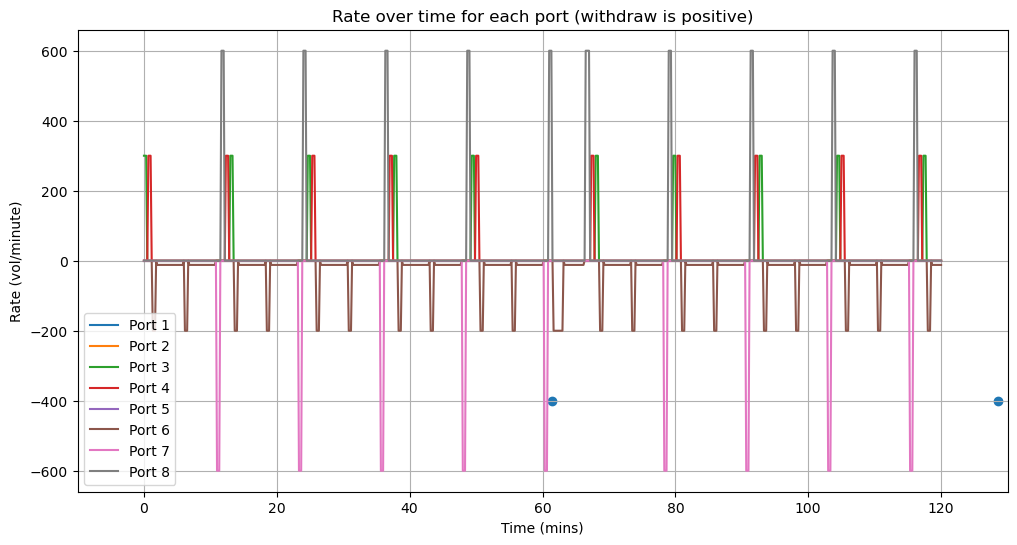

In [12]:
simul_prog,wait_times = create_PV_program_simultenious_species_v2()

df = prog_table(simul_prog)
plot_program_phases(df,hours = 2,wt = wait_times)

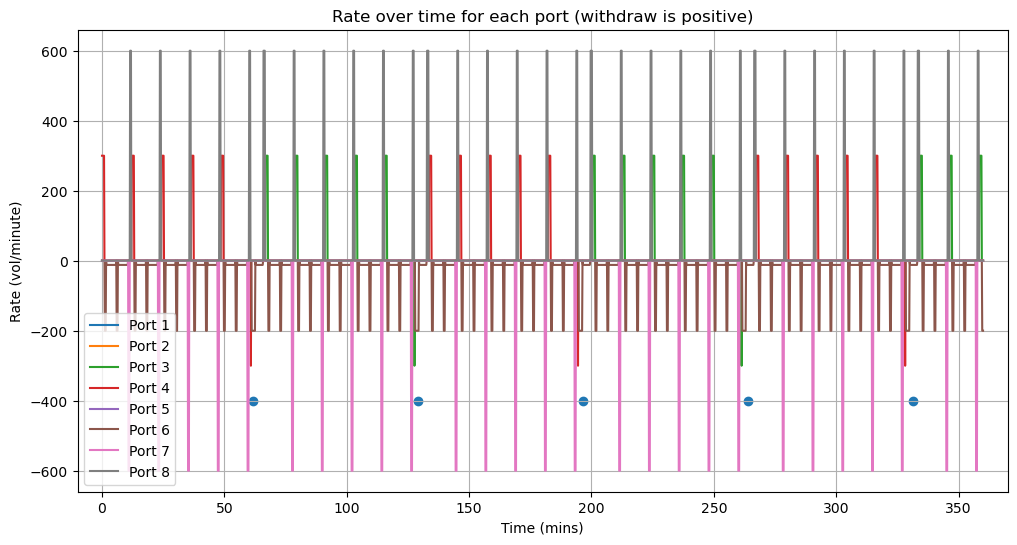

In [45]:
alter_prog,wait_times = create_PV_program_1h_alternate_2_species_v2()

df = prog_table(alter_prog)
plot_program_phases(df,hours = 6,wt = wait_times)
# plt.scatter(wt,np.ones((len(wt)))*-400)
# plt.xlim([-10,350])

In [48]:
write_pump_program_json(simul_prog,"simul_2species_json2.json")

In [49]:
write_pump_program_json(alter_prog,"alternate_1h_2species_json1.json")

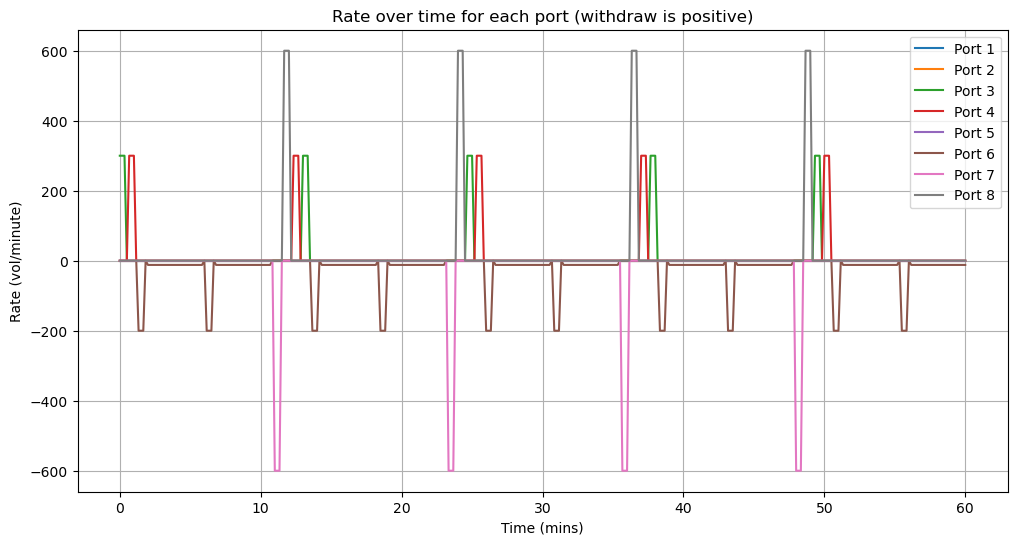

In [71]:
plot_program_phases(df)

In [98]:
alter_prog,_ = create_PV_program_1h_alternate_2_species_v2()
alter_prog

[{'type': 'make_schedule',
  'file_name': 'C:\\Users\\LevineLab\\Documents\\Repos\\Pumps\\wash_schedule',
  'cycle_times': [61.75,
   69.43,
   69.43,
   69.43,
   69.43,
   69.43,
   69.43,
   69.43,
   69.43,
   69.43,
   69.43,
   69.43]},
 {'type': 'pvflow',
  'p': 4,
  'r': 300,
  'v': 300,
  'd': 'Withdraw',
  'post_wait': 8,
  'status': '1port injection flow, step1/7, withdraw p4'},
 {'type': 'pvflow',
  'p': 6,
  'r': 200,
  'v': 100,
  'd': 'Infuse',
  'post_wait': 8,
  'status': '1port injection flow, step2/7 pulse to device p6'},
 {'type': 'pvflow',
  'p': 6,
  'r': 12,
  'v': 48,
  'd': 'Infuse',
  'post_wait': 8,
  'status': '1port injection flow, step3/7 flow to device p6'},
 {'type': 'pvflow',
  'p': 6,
  'r': 200,
  'v': 100,
  'd': 'Infuse',
  'post_wait': 8,
  'status': '1port injection flow, step4/7 pulse to device p6'},
 {'type': 'pvflow',
  'p': 6,
  'r': 12,
  'v': 48,
  'd': 'Infuse',
  'post_wait': 8,
  'status': '1port injection flow, step5/7 flow to device p6'

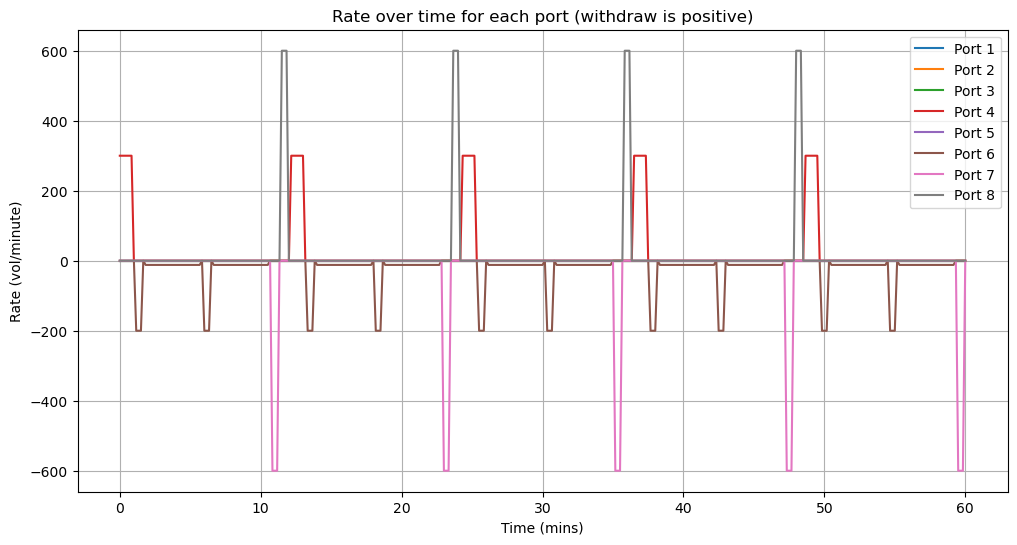

In [99]:
df = prog_table(alter_prog)
plot_program_phases(df,hours = 1)

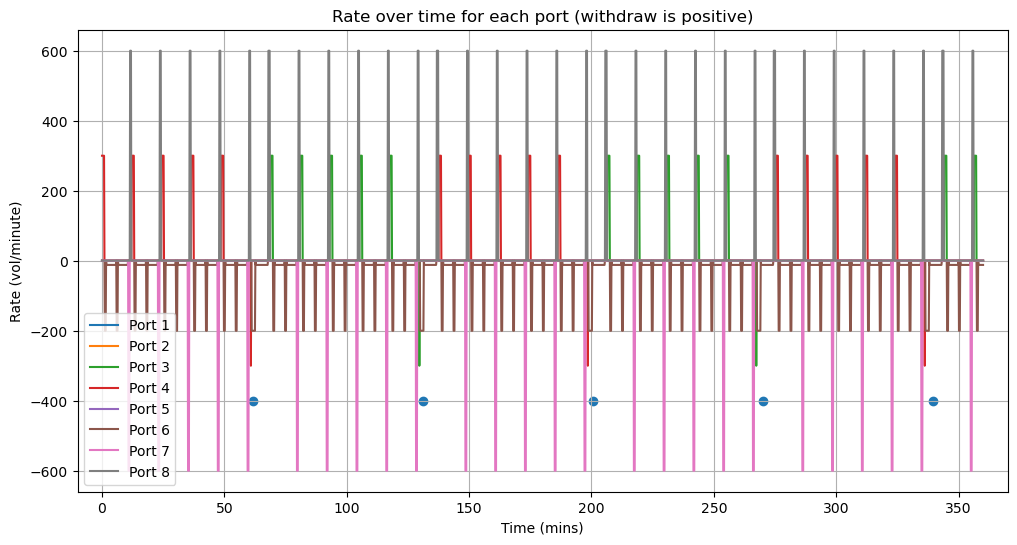

In [100]:
alter_prog,wait_times = create_PV_program_1h_alternate_2_species_v2()
# wt = accumulate_values(wait_times)
# alter_prog
df = prog_table(alter_prog)
plot_program_phases(df,hours = 6,wt = wait_times)
# plt.scatter(wt,np.ones((len(wt)))*-400)
# plt.xlim([-10,350])

In [102]:
write_pump_program_json(alter_prog,"alternate_1h_2species_json1.json")